# Experiments with textual misinformation detection using machine learning models
In this experiment, we train and test machine learning models for detecting misinformation based purely on the text. We evaluated the performance of 5 classification models with wide use in text classification problems.

**Models:**
* Logistic regression
* Bernoulli Naive-Bayes
* Multinomial Naive-Bayes
* Linear SVM
* KNN
* Random forest
* Gradient Boosting
* Multilayer Perceptron

# NOTES TO MYSELF

**To do:**
* linguistic features
* hyperparamater tunning; validation


**References:**
* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training


In [1]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

start_time = time.time()

## Experiments

## Subsets:
* Viral
* All

### Feature engineering
* bow: binary bag of words
* tfidf: term frequency–inverse document frequency
* max_features: limits to 500

### Pre-processing
* processed: convert url in just the domain, separate emojis, remove punctuation, downcase, lemmatization, remove stop words

### Data balancing
* smote: Synthetic Minority Oversampling Technique
* undersampling: random undersampling
* random_oversampling


### Conclusions:
* Smote is not the best oversampling technique for text, specially for BOW features
* Pre-processing the data didn't appear to have a great impact, despite the great reduction of dimentionality
* BOW features are comparably to TF-IDF features
* Random oversampling is a good oversampling technique
* Use a maximum number of features wasn't a good approach

In [2]:
base = '2018'
subset = 'viral'
path_dir = 'results/' + str(base) + '/' + subset + '/ml/'
path_dir

'results/2018/viral/ml/'

In [3]:
# best results analysis
df_best = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1 score', 'auc score','vocab'])
#iterates over files
exp = []
for filename in os.listdir(path_dir):
    exp.append(str(filename).replace('.csv',''))
    file_path = path_dir + filename
    #print(filename)
    df_temp = pd.read_csv(file_path)
    best_ix = df_temp['f1 score'].argmax() #f1 score
    best = df_temp.iloc[best_ix]
    df_best = df_best.append(best)
df_best['experiment'] = exp
cols = df_best.columns.tolist()
cols = cols[-2:] + cols[:-2]
df_best = df_best[cols]
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best = df_best.sort_values(by='f1 score',ascending=False)
df_best.style.background_gradient(cmap='Blues')

,vocab,experiment,model,accuracy,precision,recall,f1 score,auc score
14,21173,ml-tfidf-processed-random_oversampling,mlp,0.788079,0.747126,0.740319,0.743707,0.858634
9,21173,ml-tfidf-processed-smote,linear svm,0.789972,0.754098,0.733485,0.743649,0.000000
10,21173,ml-bow-processed-random_oversampling,logistic regression,0.794702,0.773399,0.715262,0.743195,0.848567
13,24442,ml-tfidf-random_oversampling,linear svm,0.788079,0.748268,0.738041,0.743119,0.000000
15,24442,ml-tfidf-smote,linear svm,0.787133,0.748837,0.733485,0.741082,0.000000
6,24442,ml-tfidf-undersampling,mlp,0.763482,0.682081,0.806378,0.739040,0.862386
4,24442,ml-tfidf,linear svm,0.789026,0.760870,0.717540,0.738570,0.000000
1,21173,ml-tfidf-processed,linear svm,0.789972,0.767901,0.708428,0.736967,0.000000
12,24442,ml-bow-random_oversampling,mlp,0.784295,0.759214,0.703872,0.730496,0.851358
2,24442,ml-bow,mlp,0.785241,0.763682,0.699317,0.730083,0.851892


# Begin experiment

In [4]:
pre_processed = True # the texts were already pre-processed
experiment = 'ml-tfidf-processed-random_oversampling'
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv(filepath)

if subset == 'viral':
    df = df[df['viral']==1]
    
df.head(5)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
15,3631133147603888180,10/08/18,14:31,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,99,18,1,2,"No dia 07 de Outubro, quando for votar, não es...",1
26,-4391661641377612003,11/08/18,19:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,114,17,1,6,Devido a aborrecimentos nas varias redes socia...,0
43,3631133147603888180,15/08/18,19:23,55,BRASIL,BRA,17,São Paulo,2018_1,0,1,330,47,1,7,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0
103,-4391661641377612003,22/08/18,22:11,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,226,39,1,8,Como são as coisas.\nChefe do jacaré aparece n...,1


# Corpus statistics

In [5]:
df.describe()[['characters','words','sharings']]

,characters,words,sharings
count,20872.000000,20872.000000,20872.000000
mean,530.377252,80.396560,11.232177
std,901.760873,138.349054,16.071484
min,23.000000,6.000000,2.000000
25%,108.000000,16.000000,2.000000
50%,202.000000,30.000000,5.000000
75%,482.000000,77.000000,12.000000
max,15683.000000,2664.000000,91.000000


In [6]:
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

total data


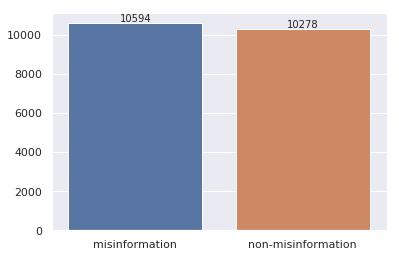

In [7]:
print('total data')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

data after remove duplicates


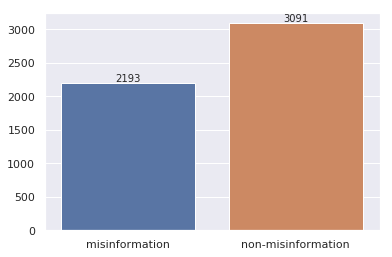

In [8]:
#removing duplicates
    
df = df.drop_duplicates(subset=['text'])    
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [9]:
print(len(texts))
print(len(y))

5284
5284


# Pre-processing
* convert url in just the domain
* separate emojis
* punctuation

[Some suggestions in this work](https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb)

* **Special character cleaning**

* **Upcase/downcase**

* **Punctuation signs** 

* **Possessive pronouns**

* **Stemming or Lemmatization**

* **Stop words**

In [10]:
#emojis and punctuation
emojis_list = list(emoji.UNICODE_EMOJI.keys())
punct = list(string.punctuation)
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = True):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:
        #remove punctuation
        if remove_punct:
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')
            if c in punct:
                text = text.replace(c, ' ')
                
        #put spaces between punctuation
        else:
            if c in emojis_punct:
                text = text.replace(c, ' ' + c + ' ')          
            
    text = text.replace('  ', ' ')
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','kkk','kkkk','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = text.replace('  ',' ')
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text
    

def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''    
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text 

def preprocess(text):
    text = text.lower().strip()
    text = domainUrl(text)
    text = processEmojisPunctuation(text)
    text = removeStopwords(text)
    text = lemmatization(text)
    return text
           

In [11]:
#if experiment is with pre-processed text
if 'processed' in experiment:
        #text was already pre-processed
        if pre_processed:
            if subset != 'viral':
                pro_texts = pickle.load(open( "data/2018/processed_texts.p", "rb" ))
            else:
                pro_texts = pickle.load(open( "data/2018/processed_texts-viral.p", "rb" ))
        else:
            pro_texts = [preprocess(t) for t in texts]
            if subset != 'viral':
                pickle.dump(pro_texts, open( "data/2018/processed_texts.p", "wb" ))
            else:
                pickle.dump(pro_texts, open( "data/2018/processed_texts-viral.p", "wb" ))
else:
    pro_texts = [t for t in texts]

In [12]:
list(zip(pro_texts[0:10], texts[0:10]))

[('o bolsonaro estar preparar responder assim ',
  'O Bolsonaro tem que estar preparado pra responder assim...'),
 ('o dia 07 outubro votar esquecer esquerdopatas pensar classe médio ',
  'No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.'),
 ('dever aborrecimento variar rede social postar nado político mulher bonito ',
  'Devido a aborrecimentos nas varias redes sociais não vou postar mais nada de política,agora so mulheres bonitas...'),
 ('eu gostar pedir todo grupo entrar neste link votar escolher candidatar presidente compartilhar maximo rede social norte sul ler oeste indiferente ideologia \n\n detalhar conseguir votar 2 vezar \n\nwww opinionstage com',
  'EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM NESTE LINK VOTE E ESCOLHA SEU CANDIDATO A PRESIDENTE E COMPARTILHEM AO MAXIMO NAS REDES SOCIAIS DE NORTE A SUL DE LESTE A OESTE , INDIFERENTE DE SUA IDEOLOGIA \n\n*Detalhe:Vc não consegue votar 2 vezes ou mais.*\n\nhttps://www.opinion

In [13]:
print(len(pro_texts))
print(len(y))

5284
5284


## Train-test split

In [14]:
#random state = 42 for reprudictibility
texts_train, texts_test, y_train, y_test = train_test_split(pro_texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

full_texts_train, full_texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

## Vectorization

In [15]:
max_feat = 500

if 'tfidf' in experiment:
    if 'max_features' in experiment:
        vectorizer = TfidfVectorizer(max_features = max_feat) 
    else:
        vectorizer = TfidfVectorizer()
        
elif 'bow' in experiment:
    if 'max_features' in experiment:
        vectorizer = CountVectorizer(max_features = max_feat, binary=True) 
    else:
        vectorizer = CountVectorizer(binary=True)

vectorizer.fit(texts_train)   
X_train = vectorizer.transform(texts_train)
X_test = vectorizer.transform(texts_test)
X = vectorizer.transform(pro_texts)

## SVD visualization

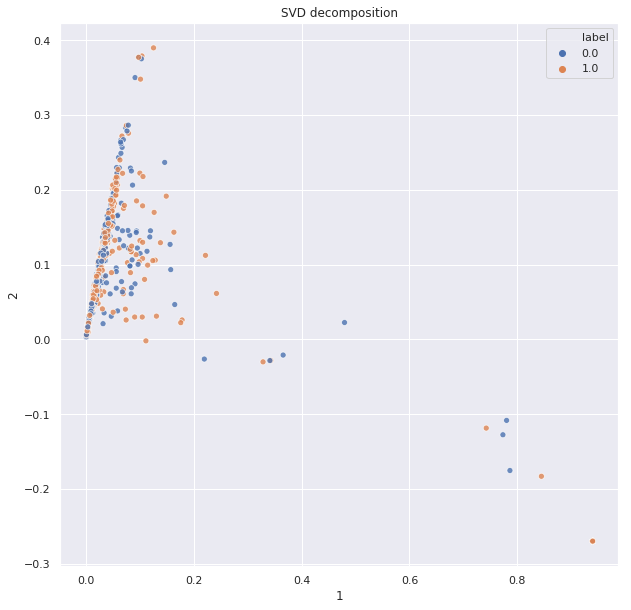

In [16]:
n_components = 2
title = "SVD decomposition"
# Creation of the model
mod = TruncatedSVD(n_components=n_components)
# Fit and transform the features
principal_components = mod.fit_transform(X)

# Put them into a dataframe
df_features = pd.DataFrame(data=principal_components,
                 columns=['1', '2'])

df_features['label'] = y

# Plot
plt.figure(figsize=(10,10))
sns.scatterplot(x='1',
                y='2',
                hue="label", 
                data=df_features,
                alpha=.8).set_title(title);

## Data balancing

In [17]:
if 'smote' in experiment:
    #oversampling with SMOTE
    sm = SMOTE(random_state = 42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
elif 'undersampling' in experiment:
    rus = RandomUnderSampler(random_state = 42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
elif 'random_oversampling' in experiment:
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
X_train.shape

(4946, 21173)

In [18]:
vocab_size = X_train.shape[1]
vocab_size

21173

## Metrics

In [19]:
scenario = []
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

## Models training and test

Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       618
           1       0.74      0.74      0.74       439

    accuracy                           0.78      1057
   macro avg       0.77      0.77      0.77      1057
weighted avg       0.78      0.78      0.78      1057

AUC:  0.8510331659921415


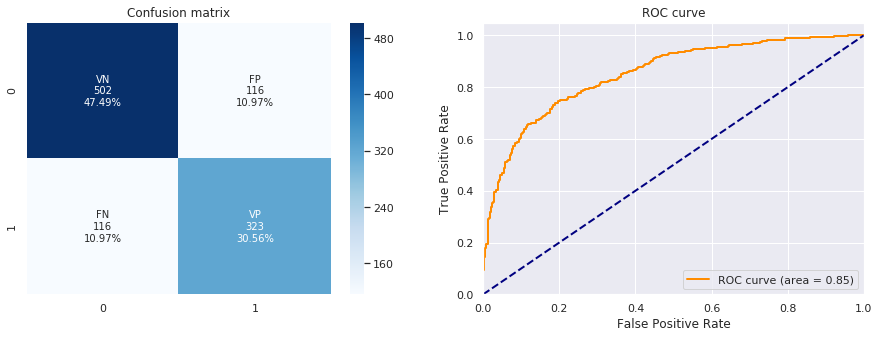

In [20]:
print('Logistic Regression')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       618
           1       0.84      0.37      0.51       439

    accuracy                           0.71      1057
   macro avg       0.76      0.66      0.65      1057
weighted avg       0.75      0.71      0.68      1057

AUC:  0.7974434394143796


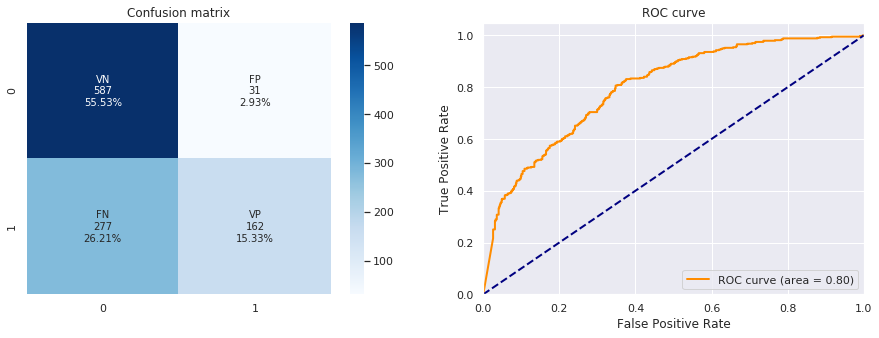

In [21]:
print('Bernoulli Naive-Bayes')
bnb = BernoulliNB().fit(X_train, y_train)
y_pred = bnb.predict(X_test)
y_prob = bnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('bernoulli naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multinomial Naive-Bayes
              precision    recall  f1-score   support

           0       0.89      0.59      0.71       618
           1       0.61      0.89      0.72       439

    accuracy                           0.72      1057
   macro avg       0.75      0.74      0.72      1057
weighted avg       0.77      0.72      0.71      1057

AUC:  0.8545864018695034


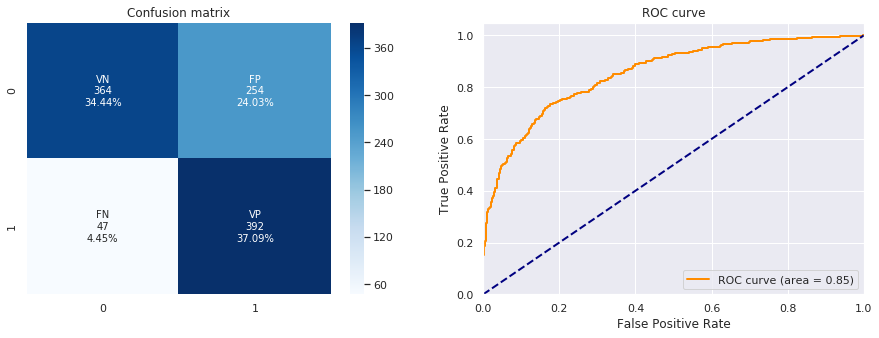

In [22]:
print('Multinomial Naive-Bayes')
mnb = MultinomialNB().fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_prob = mnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('multinomial naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Linear Support Vector Machine
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       618
           1       0.75      0.73      0.74       439

    accuracy                           0.79      1057
   macro avg       0.78      0.78      0.78      1057
weighted avg       0.79      0.79      0.79      1057



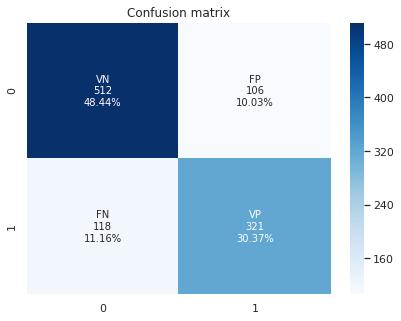

In [23]:
print('Linear Support Vector Machine')
svm = LinearSVC().fit(X_train, y_train)
y_pred = svm.predict(X_test)
#y_prob = svm.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred)

model.append('linear svm')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

KNN
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       618
           1       0.73      0.62      0.67       439

    accuracy                           0.74      1057
   macro avg       0.74      0.73      0.73      1057
weighted avg       0.74      0.74      0.74      1057

AUC:  0.8179243057552101


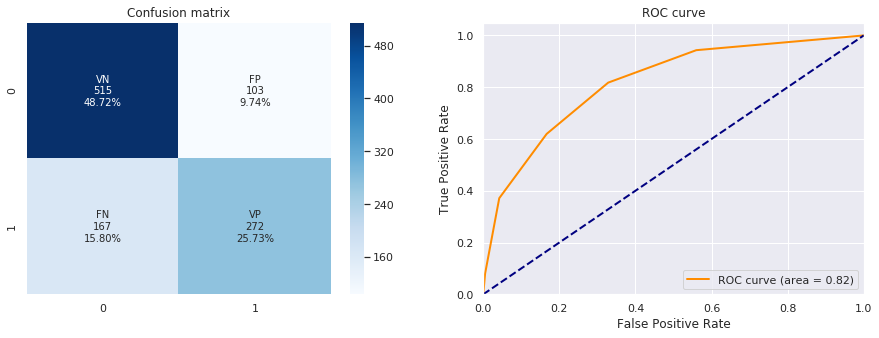

In [24]:
print('KNN')
rf = KNeighborsClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('knn')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Random Forest
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       618
           1       0.82      0.60      0.69       439

    accuracy                           0.78      1057
   macro avg       0.79      0.75      0.76      1057
weighted avg       0.78      0.78      0.77      1057

AUC:  0.8530198819028242


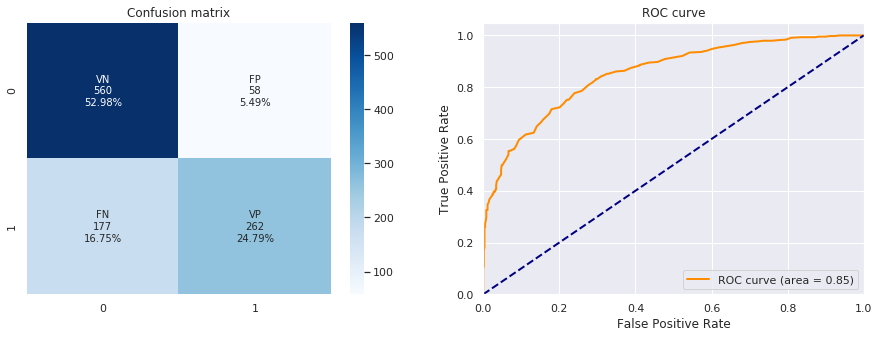

In [25]:
print('Random Forest')
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('random forest')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Gradient Boosting
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       618
           1       0.72      0.64      0.68       439

    accuracy                           0.75      1057
   macro avg       0.74      0.73      0.73      1057
weighted avg       0.75      0.75      0.74      1057

AUC:  0.8096549232958105


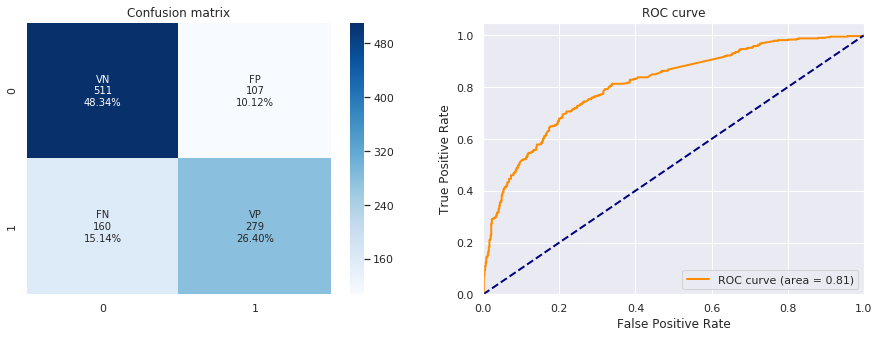

In [26]:
print('Gradient Boosting')
gb = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('gradient boosting')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multilayer perceptron
Iteration 1, loss = 0.67367633
Validation score: 0.761616
Iteration 2, loss = 0.58027622
Validation score: 0.751515
Iteration 3, loss = 0.47011526
Validation score: 0.777778
Iteration 4, loss = 0.37436031
Validation score: 0.793939
Iteration 5, loss = 0.29991891
Validation score: 0.797980
Iteration 6, loss = 0.24594678
Validation score: 0.802020
Iteration 7, loss = 0.20482998
Validation score: 0.816162
Iteration 8, loss = 0.17346693
Validation score: 0.820202
Iteration 9, loss = 0.14920082
Validation score: 0.822222
Iteration 10, loss = 0.12979984
Validation score: 0.812121
Iteration 11, loss = 0.11381147
Validation score: 0.828283
Iteration 12, loss = 0.10061322
Validation score: 0.830303
Iteration 13, loss = 0.09005479
Validation score: 0.832323
Iteration 14, loss = 0.08066366
Validation score: 0.830303
Iteration 15, loss = 0.07251698
Validation score: 0.830303
              precision    recall  f1-score   support

           0       0.82      0.83      0.82    

/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


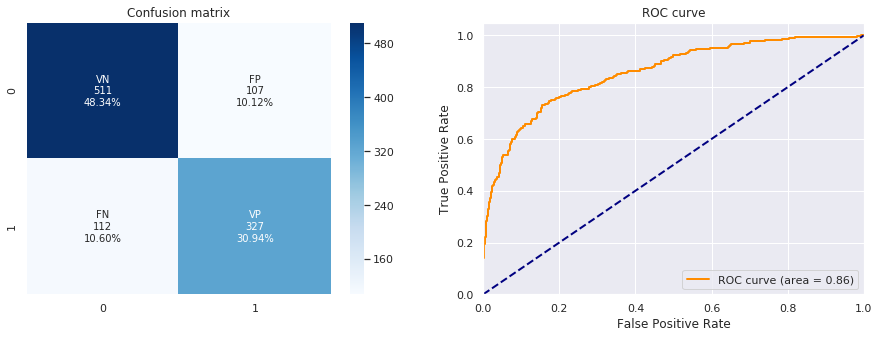

In [66]:
print('Multilayer perceptron')
mlp = MLPClassifier(max_iter=15,verbose=True, early_stopping= True).fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('mlp')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

## Results

In [28]:
end_time = time.time()
ellapsed_time = end_time - start_time
print('ellapsed time (min):', ellapsed_time/60)

ellapsed time (min): 0.6897531787554423


In [29]:
df_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})

df_metrics['vocab'] = [vocab_size]*len(df_metrics)
df_metrics

,model,accuracy,precision,recall,f1 score,auc score,vocab
0,logistic regression,0.780511,0.735763,0.735763,0.735763,0.851033,21173
1,bernoulli naive-bayes,0.708609,0.839378,0.369021,0.512658,0.797443,21173
2,multinomial naive-bayes,0.715232,0.606811,0.892938,0.722581,0.854586,21173
3,linear svm,0.788079,0.751756,0.731207,0.741339,0.000000,21173
4,knn,0.744560,0.725333,0.619590,0.668305,0.817924,21173
5,random forest,0.777673,0.818750,0.596811,0.690382,0.853020,21173
6,gradient boosting,0.747398,0.722798,0.635535,0.676364,0.809655,21173
7,mlp,0.788079,0.741573,0.751708,0.746606,0.859349,21173


In [30]:
filepath = 'results/' + base + '/' + subset + '/ml/' + experiment + '.csv'
filepath

'results/2018/viral/ml/ml-tfidf-processed-random_oversampling.csv'

In [31]:
df_metrics.to_csv(filepath, index = False)

# Error examples with mlp

In [32]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_pred = mlp.predict(X_test)
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('Total test data:', len(y_pred))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

Total test data: 1057
False negative:  109
False positive:  115


In [33]:
full_texts_test = list(full_texts_test)

In [34]:
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]

### False negative

In [35]:
for fn in texts_FN:
    print('***')
    print(fn)
    print('***')

***
Gente Apenas Minha Opinião então Vamos lá

No Dia 06 de Junho TSE Derruba o Voto Impresso de Autoria do deputado Federal Candidato a presidente Jair Bolsonaro

No Dia 06 de Setembro Jair Bolsonaro Sofre um Atentado que Seria pra MATAR

Um Dia Antes da Eleição Dia 06; Coincidência Se Juntar as Datas dar Certos 666 
Agora Bolsonaro corre novo Risco...

A que Interessa Isso ? Nova Ordem Mundial / Marconaria ? / iluminati ? / 
Peço que Compartilhem 
E Faca Chegar ao Bolsonaro

Breno Washington MG
Juntos somos fortes
***
***
A morte da velha política no Brasil, comentário de Alexandre Garcia.👇🏻👇🏻👇🏻
***
***
.


Inclusive eu tenho uma cunhada que era contra o BOLSONARO 
Depois do ocorrido com o mito ela virou o voto dela é das três filhas 
Agora elas são BOLSONARO 
Tudo porque ela não gostou da covardia que fizeram com BOLSONARO 
É isso aí vamo que vamo 
👍🏾👍🏾👍🏾👍🏾👍🏾
Que Deus olhe por todos nós
***
***
POR ALINE PEREIRA: Republico aqui um post do mês passado, onde conto uma experiência que 

### False positives

In [36]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
Quando o eleitor de haddad olha para o eleitor de Bolsonaro 🤣
***


***
TEXTO DA FUNDADORA DO DIRETÓRIO DO PT EM ARACAJU

Esquerda brasileira, chega de apontar culpados! Está na hora de assumir o ocorrido e partir prum mea culpa já!, antes que os Dórias e Bolssonaros assumam o poder! Quem elegeu Temer não foram os coxinhas. Parem de tergiversar. Temer foi eleito por vocês com dinheiro público desviado de hospitais, creches e escolas! O resto é retórica, ou ilação como vocês agora costumam chamar o que nós brasileiros conhecemos como mentira!

A arrogância da esquerda de acreditar que lida com tolos e que porta o Santo Graal está no pano de fundo de sua derrocada mundo afora.

Vamos fazer diferente e lavar a jato essa roupa suja antes que seja tarde! A máscara caiu!

Um homem que responsabiliza a companheira morta para não assumir seus atos é um covarde e não herói . Essa inversão de valores para mim é assustadora...

E não me venham falar da corrupção que existe desde a época de C

# MLP Hyperparameter tunning with random search

In [37]:
#validation set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify = y_train)

In [67]:
activation = ['logistic', 'tanh', 'relu']
for i in range(10):
    print(np.random.randint(5,30))

17
19
25
6
7
13
25
10
7
28


In [65]:
def randomLayers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(50,300)
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

       
print(randomLayers())
    

(79, 126)


## Hyperparameters

MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)[source].

In [77]:
hyperparams = []
best_hyperpams = []
results = []
n_iter = 15
best_score = 0
np.random.seed(42)

activation_list = ['logistic', 'tanh', 'relu']
solver_list = ['sgd', 'adam', 'lbfgs']
learning_rate_list = ['constant','adaptive']

for i in range(n_iter):
    print(str(i+1) + '/' + str(n_iter))
    
    # hidden layers
    hidden_layer_sizes = randomLayers()
    
    #activation
    s = np.random.randint(len(activation_list))
    activation = activation_list[s]
    
    #solver
    s = np.random.randint(len(solver_list))
    solver = solver_list[s]
    
    #alpha
    s = np.random.uniform(-5,-1)
    alpha = 10**s
    
    #learning rate
    s = np.random.randint(len(learning_rate_list))
    learning_rate = learning_rate_list[s]
    
    # max of iterations during training
    max_iter = np.random.randint(10,100) 
   
    hyperparams.append([hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter])
    
    print('training: ')
    print(hyperparams[i])
    
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                        activation=activation, 
                        solver=solver, 
                        alpha=alpha, 
                        learning_rate=learning_rate, 
                        max_iter = max_iter,
                        verbose=True, early_stopping= True, 
                        n_iter_no_change = 5).fit(X_train_val, y_train_val)
    
    y_pred = mlp.predict(X_val)
    y_prob = mlp.predict_proba(X_val)[:,1]    
    score = metrics.f1_score(y_val, y_pred, pos_label = 1, average = 'binary')
    results.append(score)
    
    if score > best_score:
        best_score = score
        best_hyperpams = [hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter]  
        
        
val_data = list(zip(results,hyperparams))    
val_data = sorted(val_data, key=lambda tup: tup[0],reverse = True)
val_data 

1/15
training: 
[(229, 142, 64), 'relu', 'sgd', 0.002440060709081752, 'adaptive', 92]
Iteration 1, loss = 0.70230347
Validation score: 0.500000
Iteration 2, loss = 0.70054680
Validation score: 0.500000
Iteration 3, loss = 0.69906017
Validation score: 0.500000
Iteration 4, loss = 0.69831616
Validation score: 0.500000
Iteration 5, loss = 0.69806191
Validation score: 0.500000
Iteration 6, loss = 0.69775760
Validation score: 0.500000
Iteration 7, loss = 0.69748519
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Setting learning rate to 0.000200
Iteration 8, loss = 0.69732635
Validation score: 0.497758
Iteration 9, loss = 0.69726363
Validation score: 0.500000
Iteration 10, loss = 0.69723927
Validation score: 0.506726
Iteration 11, loss = 0.69724086
Validation score: 0.502242
Iteration 12, loss = 0.69722027
Validation score: 0.502242
Iteration 13, loss = 0.69720954
Validation score: 0.502242
Iteration 14, loss = 0.69719783
Validati

Iteration 4, loss = 0.13439552
Validation score: 0.847534
Iteration 5, loss = 0.09833039
Validation score: 0.831839
Iteration 6, loss = 0.07986626
Validation score: 0.820628
Iteration 7, loss = 0.07110505
Validation score: 0.822870
Iteration 8, loss = 0.06172975
Validation score: 0.816143
Iteration 9, loss = 0.05680537
Validation score: 0.811659
Iteration 10, loss = 0.06168084
Validation score: 0.820628
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
9/15
training: 
[(113,), 'tanh', 'adam', 0.02468442600156402, 'constant', 22]
Iteration 1, loss = 0.66927851
Validation score: 0.755605
Iteration 2, loss = 0.56777531
Validation score: 0.775785
Iteration 3, loss = 0.49017895
Validation score: 0.778027
Iteration 4, loss = 0.42779291
Validation score: 0.789238
Iteration 5, loss = 0.37939110
Validation score: 0.795964
Iteration 6, loss = 0.34088227
Validation score: 0.795964
Iteration 7, loss = 0.31161114
Validation score: 0.795964
Iteration 8, loss

/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


12/15
training: 
[(74, 50), 'relu', 'sgd', 0.0002530539189416304, 'adaptive', 77]
Iteration 1, loss = 0.69404723
Validation score: 0.500000
Iteration 2, loss = 0.69383700
Validation score: 0.500000
Iteration 3, loss = 0.69351654
Validation score: 0.500000
Iteration 4, loss = 0.69331662
Validation score: 0.500000
Iteration 5, loss = 0.69302659
Validation score: 0.500000
Iteration 6, loss = 0.69292356
Validation score: 0.500000
Iteration 7, loss = 0.69282223
Validation score: 0.502242
Iteration 8, loss = 0.69276118
Validation score: 0.502242
Iteration 9, loss = 0.69269610
Validation score: 0.502242
Iteration 10, loss = 0.69263946
Validation score: 0.520179
Iteration 11, loss = 0.69258375
Validation score: 0.513453
Iteration 12, loss = 0.69252536
Validation score: 0.524664
Iteration 13, loss = 0.69245374
Validation score: 0.511211
Iteration 14, loss = 0.69239819
Validation score: 0.538117
Iteration 15, loss = 0.69239451
Validation score: 0.573991
Iteration 16, loss = 0.69229152
Validation

Iteration 37, loss = 0.69320002
Validation score: 0.493274
Iteration 38, loss = 0.69320038
Validation score: 0.502242
Iteration 39, loss = 0.69319991
Validation score: 0.506726
Iteration 40, loss = 0.69320016
Validation score: 0.491031
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Setting learning rate to 0.000002
Iteration 41, loss = 0.69319975
Validation score: 0.500000
Iteration 42, loss = 0.69320025
Validation score: 0.493274
Iteration 43, loss = 0.69320068
Validation score: 0.495516
Iteration 44, loss = 0.69320052
Validation score: 0.500000
Iteration 45, loss = 0.69320064
Validation score: 0.493274
Iteration 46, loss = 0.69320015
Validation score: 0.497758
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Setting learning rate to 0.000000
Iteration 47, loss = 0.69319993
Validation score: 0.495516
Iteration 48, loss = 0.69319992
Validation score: 0.495516
Iteration 49, loss = 0.69319996
Validation score: 0.500000
I

[(0.8373015873015872,
  [(113,), 'tanh', 'adam', 0.02468442600156402, 'constant', 22]),
 (0.83399209486166,
  [(146, 254), 'relu', 'lbfgs', 0.008099083297224507, 'constant', 83]),
 (0.832, [(95, 223), 'tanh', 'adam', 0.04068779845969068, 'adaptive', 94]),
 (0.8249496981891349,
  [(238, 284), 'tanh', 'adam', 0.0010249254454604625, 'adaptive', 14]),
 (0.8242424242424243,
  [(210, 99), 'logistic', 'adam', 4.2283608642382426e-05, 'adaptive', 61]),
 (0.8117154811715481,
  [(154, 151, 94), 'logistic', 'adam', 0.0004438021707008432, 'constant', 30]),
 (0.8031809145129224,
  [(279, 67, 103), 'tanh', 'adam', 0.0034147670266668284, 'adaptive', 76]),
 (0.6657681940700809,
  [(247, 276, 115),
   'logistic',
   'adam',
   0.0029648570890899446,
   'adaptive',
   54]),
 (0.6657681940700809,
  [(110, 148, 187),
   'logistic',
   'lbfgs',
   0.0004672536151753742,
   'adaptive',
   83]),
 (0.6657681940700809,
  [(84, 217, 86),
   'logistic',
   'lbfgs',
   1.5184926791229914e-05,
   'adaptive',
   95]

In [78]:
#best_hyperpams = [hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter]
hidden_layer_sizes = best_hyperpams[0]
activation = best_hyperpams[1]
solver = best_hyperpams[2]
alpha = best_hyperpams[3]
learning_rate = best_hyperpams[4]
max_iter = best_hyperpams[5]
best_hyperpams

[(113,), 'tanh', 'adam', 0.02468442600156402, 'constant', 22]

In [79]:
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                    activation=activation, 
                    solver=solver, 
                    alpha=alpha, 
                    learning_rate=learning_rate, 
                    max_iter = max_iter,
                    verbose=True, early_stopping= True, 
                    n_iter_no_change = 5).fit(X_train, y_train)

Iteration 1, loss = 0.66312974
Validation score: 0.709091
Iteration 2, loss = 0.54867411
Validation score: 0.765657
Iteration 3, loss = 0.45860606
Validation score: 0.773737
Iteration 4, loss = 0.38922438
Validation score: 0.775758
Iteration 5, loss = 0.33727815
Validation score: 0.785859
Iteration 6, loss = 0.29831782
Validation score: 0.785859
Iteration 7, loss = 0.26915548
Validation score: 0.787879
Iteration 8, loss = 0.24648310
Validation score: 0.783838
Iteration 9, loss = 0.22836007
Validation score: 0.791919
Iteration 10, loss = 0.21381539
Validation score: 0.795960
Iteration 11, loss = 0.20062464
Validation score: 0.797980
Iteration 12, loss = 0.19051331
Validation score: 0.789899
Iteration 13, loss = 0.18119876
Validation score: 0.791919
Iteration 14, loss = 0.17345489
Validation score: 0.793939
Iteration 15, loss = 0.16672841
Validation score: 0.795960
Iteration 16, loss = 0.16138153
Validation score: 0.791919
Iteration 17, loss = 0.15608030
Validation score: 0.789899
Valida

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       618
           1       0.75      0.73      0.74       439

    accuracy                           0.79      1057
   macro avg       0.78      0.78      0.78      1057
weighted avg       0.79      0.79      0.79      1057

AUC:  0.8565436303455191


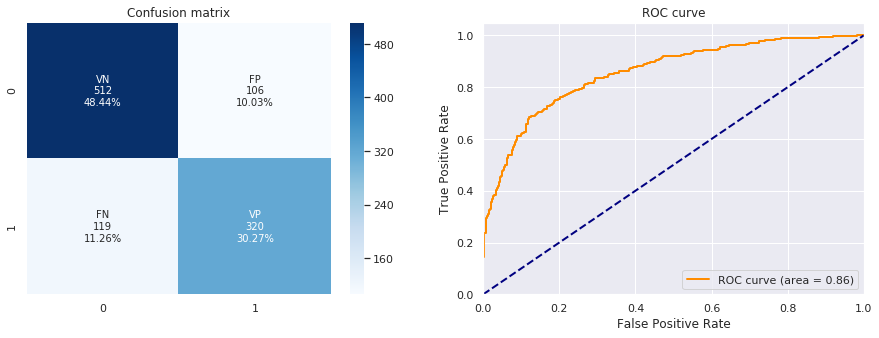

In [80]:
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

In [81]:
print([acc, precision, recall, f1, roc_auc])

[0.7871333964049196, 0.7511737089201878, 0.7289293849658315, 0.7398843930635839, 0.8565436303455191]
